In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()

from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.psf import PSF

In [3]:
lens_model_list = ['SIE', 'SHEAR']

kwargs_spemd = {'theta_E': 1.7, 'e1': 0.07, 'e2': -0.03, 'center_x': 0.05, 'center_y': -0.25}
kwargs_shear = {'gamma1': 0.1, 'gamma2': -0.05}

kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list)

lens_light_model_list = ['SERSIC_ELLIPSE']

kwargs_sersic_lens = {'amp': 10, 'R_sersic': 0.6, 'n_sersic': 2, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.05, 'center_y': 0}

kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(lens_light_model_list)

source_model_list = ['SERSIC_ELLIPSE']

kwargs_sersic = {'amp': 10, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}

kwargs_source_light = [kwargs_sersic]
source_model_class = LightModel(source_model_list)

In [4]:
num_pix = 45
delta_pix = 0.11  # size of pixel in angular coordinates
ra_at_xy_0, dec_at_xy_0 = -delta_pix * math.ceil(num_pix / 2), -delta_pix * math.ceil(num_pix / 2) # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * delta_pix  # linear translation matrix of a shift in pixel in a shift in coordinates

kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)

kwargs_psf = {'psf_type': 'NONE'}
psf_class = PSF(**kwargs_psf)

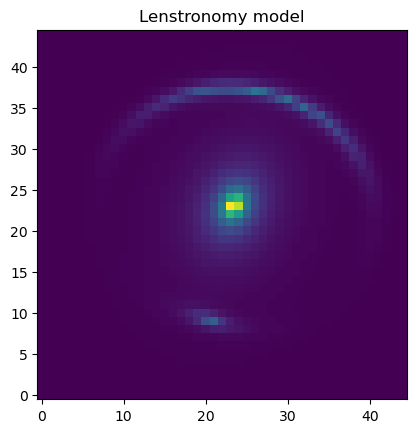

In [5]:
kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False}

imageModel = ImageModel(data_class=pixel_grid,
                        psf_class=psf_class,
                        lens_model_class=lens_model_class,
                        source_model_class=source_model_class,
                        lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

kwargs_model = {'lens_model_list': lens_model_list,
                'lens_light_model_list': lens_light_model_list,
                'source_light_model_list': source_model_list}

image = imageModel.image(kwargs_lens=kwargs_lens,
                         kwargs_source=kwargs_source_light,
                         kwargs_lens_light=kwargs_lens_light)

plt.imshow(image, origin='lower')
plt.title('Lenstronomy model')
plt.savefig('figures/model.png')
plt.show()

In [6]:
from astropy.io import fits

hdul = fits.HDUList()
hdul.append(fits.PrimaryHDU())
hdul.append(fits.ImageHDU(data=image))

hdul.writeto('output.fits', overwrite=True)

In [7]:
np.save('model', image)